# Setup

In [1]:
import numpy as np
from numpy import random
import re
import pickle
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

from pathlib import Path
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
from dataset import Dataset

from keras import losses, models, optimizers, initializers, regularizers

from keras.models import Sequential, Model, model_from_json

from keras.preprocessing.text import Tokenizer

from keras.layers import (Layer, Input, Flatten, Dropout, BatchNormalization, Reshape, Embedding,
                          MaxPool1D, AveragePooling1D, GlobalAveragePooling1D,
                          Conv1D, SeparableConv1D, Dense, LeakyReLU, ReLU, Activation,
                          LSTM, SimpleRNNCell, Bidirectional)

# Dataset Load

690 lines skipped (not labeled)
0 lines skipped (not text)
Total filtered labels: 171
Text Length Max:  67
Text Length Min:  1
Text Length Mode: 6
Text Length Mean: 8.42
Text Length Std:  4.18
S/W Text Ratio:   8.42


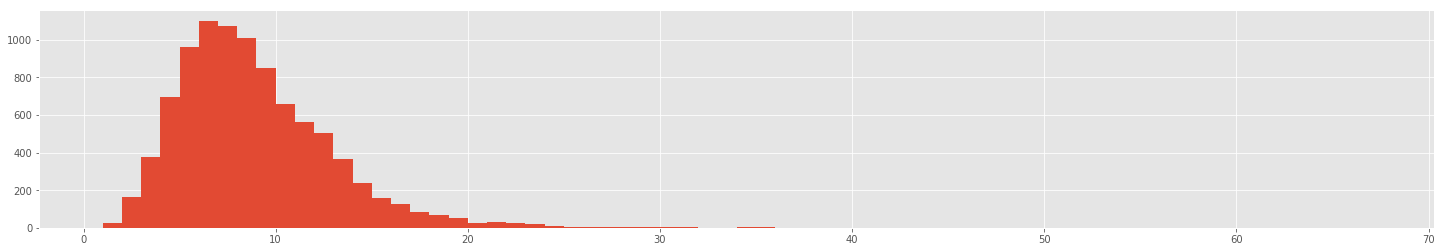

In [3]:
filename = 'datasets/amazon_co-ecommerce_sample.csv'
text_field='name'

dataset = Dataset(filename)
dataset.load(text_field=text_field, label_field='category')
dataset.filer_data()
dataset.text_info()

# Embedding

### Tokenizer

In [4]:
tokenizer = dataset.tokenize()
word_index = tokenizer.word_index

Number of Tokens: 12960


### Embedding Layer

In [5]:
train_word2vec = False
if train_word2vec:
    size = 100
    max_vocab_size = 20000

    sentences = dataset.text.transform(lambda t: t.split())

    embedding = Word2Vec(sentences, size=size,
                         max_vocab_size=max_vocab_size)

    output_file = 'embeddings/{}_s{}.txt'.format('word2vec', size)
    embedding.wv.save_word2vec_format(output_file)

In [6]:
embedding_filename = 'embeddings/model.txt'

embedding = KeyedVectors.load_word2vec_format(embedding_filename)

embedding_matrix = np.zeros((len(word_index) + 1, embedding.vector_size))
for word, i in word_index.items():
    try:
        embedding_vector = embeddings.get_vector(word)
        embedding_matrix[i] = embedding_vector
    except:
        pass

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding.vector_size,
                            weights=[embedding_matrix],
                            input_length=dataset.max_text(),
                            trainable=True)

# CNN

### SepCNN

In [7]:
use_sepcnn = False
if use_sepcnn: 
    
    # Hyper Parameters
    blocks       = 1
    filters      = 32
    kernel_size  = 3
    dropout_rate = 0.2
    pool_size    = 3
    
    input_layer = Input(shape=(dataset.max_text(),), dtype='int32')
    x = embedding_layer(input_layer)

    for _ in range(blocks-1):
        x = Dropout(rate=dropout_rate)(x)   
        x = SeparableConv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                            bias_initializer='random_uniform', depthwise_initializer='random_uniform',
                            padding='same')(x)
        x = SeparableConv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                            bias_initializer='random_uniform', depthwise_initializer='random_uniform',
                            padding='same')(x) 
        x = MaxPool1D(pool_size=pool_size)(x) 

    x = SeparableConv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu',
                        bias_initializer='random_uniform', depthwise_initializer='random_uniform',
                        padding='same')(x) 
    x = SeparableConv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu',
                        bias_initializer='random_uniform', depthwise_initializer='random_uniform',
                        padding='same')(x) 
    x = GlobalAveragePooling1D()(x) 
    x = Dropout(rate=dropout_rate)(x) 

    output_layer = Dense(dataset.label_unique.size, activation='softmax')(x)

    model = Model(input_layer, output_layer)
    model.name = 'sepcnn_' + text_field
    model.summary()

# RNN

### Jatana LSTM 

This model was based on the models used in this [article](https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f). Here you can find the [GitHub Repository](https://github.com/jatana-research/Text-Classification/blob/master/RNN.ipynb) for this model implementation

In [8]:
use_jatana_lstm = True
if use_jatana_lstm:
    
    # Hyper Parameters
    units       = 100
    drop_ratio  = 0.2
    
    input_layer = Input(shape=(dataset.max_text(),), dtype='int32')
    x = embedding_layer(input_layer)
    x = Bidirectional(LSTM(units, dropout=drop_ratio))(x)
    output_layer = Dense(dataset.label_unique.size, activation='softmax')(x)

    model = Model(input_layer, output_layer)
    model.name = 'lstm_jatana_' + text_field
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 67)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 67, 300)           3888300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 171)               34371     
Total params: 4,243,471
Trainable params: 355,171
Non-trainable params: 3,888,300
_________________________________________________________________


# Save Model Architecture

In [9]:
model.save('created_models/'+ model.name + '.h5')